# Task 01: Perceptron Algorithm
Learning  Task  1:  Build  a  classifier  (Perceptron  Model  -  PM1)  using  the  perceptron  algorithm. 
Figure out whether the data set is linearly separable by building the model. By changing the order 
of the training examples, build another classifier (PM2) and outline the differences between the 
models – PM1 and PM2.  

Here we shouldn't use normalized data

## Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils_ml import generate_confusion_matrix

## Importing the dataset

In [2]:
# Read the csv file
dataset = pd.read_csv('../dataset.csv')
print(dataset.shape)

(569, 32)


In [3]:
# Convert cancer type into a new column
dataset["cancer_type"] = pd.factorize(dataset["diagnosis"])[0]
dataset["cancer_type"] = dataset["cancer_type"].replace(0, -1)
dataset.head()

# Malignant is -1 and Benign is 1

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cancer_type
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,-1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,-1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,-1


In [4]:
# Remove ID and diagnosis from the dataset
dataset.drop(['id', 'diagnosis'], axis=1, inplace=True)

# Drop NA rows because in first one we shouldn't use NA
dropped_dataset = dataset.dropna()

print(dropped_dataset[dropped_dataset.isna().any(axis=1)])

Empty DataFrame
Columns: [radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, cancer_type]
Index: []

[0 rows x 31 columns]


# Perceptron Class
- Takes in dataset also as input so that it can manage the various inputs given to it

In [4]:
class Perceptron():
    def __init__(self, dataset: pd.DataFrame, is_normalized: bool = False):
        # Initializing the dataset
        self.dataset = dataset
        if is_normalized:
            self.dataset = self.dataset.fillna(dataset.mean(numeric_only=True))  

        self.training_dataset = self.dataset.iloc[:int(
            0.67*self.dataset.shape[0]), :]

        self.testing_dataset = self.dataset.iloc[int(
            0.67*self.dataset.shape[0]):, :]
        
        if is_normalized:
            mean = self.training_dataset.iloc[:, :-1].mean(numeric_only=True)
            std = self.training_dataset.iloc[:, :-1].std()
            self.training_dataset.iloc[:, :-1] = (self.training_dataset.iloc[:, :-1] - mean)/std
            self.testing_dataset.iloc[:, :-1] = (self.testing_dataset.iloc[:, :-1] - mean)/std 

        # Add bias column to start
        self.training_dataset.insert(30, column="bias", value = 1)
        self.testing_dataset.insert(30, column="bias", value = 1)

        # print(self.training_dataset.head())
        # print(self.testing_dataset.head())

        # Split data into train and test
        self.X_train = self.training_dataset.iloc[:, :-1].values
        self.y_train = self.training_dataset.iloc[:, -1].values
        self.X_test = self.testing_dataset.iloc[:, :-1].values
        self.y_test = self.testing_dataset.iloc[:, -1].values
        # print(self.y_train, self.y_test)

        # Make an initial array of w
        self.w = np.zeros(self.dataset.shape[1])

        # We keep track of w and the accuracy where we get max accuracy
        self.max_accuracy = {"w": self.w,
                             "training_accuracy": 0.0, "testing_accuracy": 0.0, "confusion_matrix": None}

        self.accuracy_array_testing = []
        self.accuracy_array_training = []

        self.y_test_predicted = []

    # This function is brute forcing through all the possible values
    def train(self) -> np.ndarray:
        # We initialize training_done to False
        training_done = False

        count = 0

        # We loop till it's done
        while(not training_done):
            # We iterate through all the training data
            for index, x in enumerate(self.X_train):
                # We use the formula w*x*l <= 0
                if (self.y_train[index] * np.dot(self.w, x)) <= 0:
                    # If yes, we add l*x
                    self.w += self.y_train[index]*x
                    # We keep track of count
                    count += 1
                    break
            else:
                training_done = True
        print(f"Vector w: {self.w}")
        print(f"Number of Iterations: {count}")
        return self.w

    def epoch_train(self, epoch: int = 100, learning_rate: float = 1.0, initial_weights: np.ndarray = None) -> np.ndarray:
        # Here instead of using while loop, we use epochs
        count = 0

        # If initial weights is given, we use the same and continue
        # Otherwise we start from scratch
        if(initial_weights is None):
            self.w = np.zeros(self.dataset.shape[1])
        else:
            self.w = initial_weights

        # We keep a max_accuracy to keep track of the w/accuracy for which we get max_accuracy
        self.max_accuracy = {
            "w": self.w,
            "training_accuracy": self.check_training_accuracy(),
            "testing_accuracy": self.check_test_accuracy(),
            "confusion_matrix": self.show_confusion_matrix()
        }

        # Loop through all the epochs
        for _ in range(epoch):
            # Check accuracy
            testing_accuracy = self.check_test_accuracy()
            training_accuracy = self.check_training_accuracy()
            # Store that accuracy in the accuracy array
            self.accuracy_array_testing.append(testing_accuracy)
            self.accuracy_array_training.append(training_accuracy)
            # If accuracy > max, change max
            if(training_accuracy > self.max_accuracy["training_accuracy"]):
                self.max_accuracy = {
                    "w": self.w,
                    "training_accuracy": self.check_training_accuracy(),
                    "testing_accuracy": self.check_test_accuracy(),
                    "confusion_matrix": self.show_confusion_matrix()
                }

            for index, x in enumerate(self.X_train):
                # We use the formula w*x*l <= 0
                if (self.y_train[index] * np.dot(self.w, x)) <= 0:
                    # If yes, we add l*x
                    self.w += self.y_train[index]*x*learning_rate
                    # We keep track of count
                    count += 1
                    break
        # Printing result in the end
        print(f"Vector w: {self.w}")
        print(f"Number of Iterations: {count}")
        return self.w
    
    def predict(self, x_input):
        return 1 if np.dot(self.w, x_input) > 0 else -1

    # We plot the accuracy of the function, by using the accuracy
    def plot_accuracy(self):
        plt.title("Testing vs training accuracy")
        plt.plot([i for i in range(len(self.accuracy_array_testing))], self.accuracy_array_testing, label='Test')
        plt.plot([i for i in range(len(self.accuracy_array_training))], self.accuracy_array_training, label='Train')
        plt.legend()

    # A function to find the accuracy score of the data for the testing data
    def check_test_accuracy(self):
        y_predicted = [self.predict(x) for x in self.X_test]
        self.y_test_predicted = y_predicted
        return generate_confusion_matrix(y_pred=np.array(y_predicted), y_true=self.y_test)[0]

    # A function to find the accuracy score of the data for the training data
    def check_training_accuracy(self):
        y_predicted = [self.predict(x) for x in self.X_train]
        # print(y_predicted, self.y_train)
        return generate_confusion_matrix(y_pred=np.array(y_predicted), y_true=self.y_train)[0]

    def show_confusion_matrix(self):
        cm = generate_confusion_matrix(y_true=(self.y_test), y_pred=np.array(self.y_test_predicted))

        accuracy = cm[0]
        precision = cm[1]
        recall = cm[2]
        f1 = cm[3]
        
        return accuracy, precision, f1, recall


# PM1

In [6]:
# Make a pm1 model
pm1 = Perceptron(dataset=dropped_dataset)

# Train using the epoch version of the code
w = pm1.epoch_train(epoch=20000, learning_rate=.3, initial_weights=np.array([ 8.28967480e+04, 7.98768000e+03,  1.74908890e+05, -7.43540000e+03,
 -2.23401120e+03, -9.99759771e+03, -1.48236799e+04, -6.29868909e+03,
 -1.98387120e+03, -6.64827800e+02,  2.16262450e+03,  1.33876337e+04,
 -2.35118118e+04, -1.40105380e+04, -2.70731311e+02, -1.97338704e+03,
 -2.85931701e+03, -7.63689420e+02, -1.71193717e+02, -1.84277018e+02,
  8.21747420e+04, -6.61513200e+04, -9.18117500e+04, -2.72340000e+03,
 -4.69622547e+03, -3.32330294e+04, -4.15402974e+04, -1.19709215e+04,
 -6.11177080e+03, -3.27369778e+03,  1.17740000e+04]))

Vector w: [ 8.28898330e+04  7.97424000e+03  1.74788029e+05 -7.63307000e+03
 -2.23451683e+03 -1.00000891e+04 -1.48262974e+04 -6.29947186e+03
 -1.98448842e+03 -6.65205902e+02  2.16222088e+03  1.33896644e+04
 -2.35207470e+04 -1.40243530e+04 -2.70769816e+02 -1.97412406e+03
 -2.85985406e+03 -7.63769475e+02 -1.71336565e+02 -1.84374429e+02
  8.21677400e+04 -6.61617480e+04 -9.20002370e+04 -2.85285000e+03
 -4.69713723e+03 -3.32425305e+04 -4.15475501e+04 -1.19724923e+04
 -6.11369113e+03 -3.27493320e+03  1.17734000e+04]
Number of Iterations: 100


In [7]:
# Print testing and training accuracy
print(pm1.check_training_accuracy())
print(pm1.check_test_accuracy())

0.9416445623342176
0.8817204301075269


In [8]:
# Print the max accuracy and the respective w
pm1.max_accuracy

{'w': array([ 8.28898330e+04,  7.97424000e+03,  1.74788029e+05, -7.63307000e+03,
        -2.23451683e+03, -1.00000891e+04, -1.48262974e+04, -6.29947186e+03,
        -1.98448842e+03, -6.65205902e+02,  2.16222088e+03,  1.33896644e+04,
        -2.35207470e+04, -1.40243530e+04, -2.70769816e+02, -1.97412406e+03,
        -2.85985406e+03, -7.63769475e+02, -1.71336565e+02, -1.84374429e+02,
         8.21677400e+04, -6.61617480e+04, -9.20002370e+04, -2.85285000e+03,
        -4.69713723e+03, -3.32425305e+04, -4.15475501e+04, -1.19724923e+04,
        -6.11369113e+03, -3.27493320e+03,  1.17734000e+04]),
 'training_accuracy': 0.9549071618037135,
 'testing_accuracy': 0.8924731182795699,
 'confusion_matrix': (0.8924731182795699,
  0.984251968503937,
  0.9259259259259259,
  0.8741258741258742)}

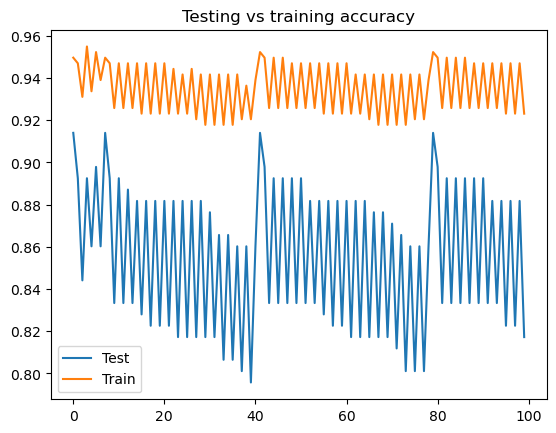

In [9]:
pm1.plot_accuracy()

In [10]:
pm1.show_confusion_matrix()

(0.8817204301075269, 1.0, 0.9166666666666666, 0.8461538461538461)

# PM2

In [11]:
shuffled_dataset2 = dropped_dataset.sample(frac=1, random_state=2)
shuffled_dataset2.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cancer_type
334,12.300,19.02,77.88,464.4,0.08313,0.04202,0.007756,0.008535,0.1539,0.05945,...,28.46,84.53,544.3,0.1222,0.09052,0.03619,0.03983,0.2554,0.07207,1
176,9.904,18.06,64.60,302.4,0.09699,0.12940,0.130700,0.037160,0.1669,0.08116,...,24.39,73.07,390.2,0.1301,0.29500,0.34860,0.09910,0.2614,0.11620,1
417,15.500,21.08,102.90,803.1,0.11200,0.15710,0.152200,0.084810,0.2085,0.06864,...,27.65,157.10,1748.0,0.1517,0.40020,0.42110,0.21340,0.3003,0.10480,-1
77,18.050,16.15,120.20,1006.0,0.10650,0.21460,0.168400,0.108000,0.2152,0.06673,...,18.91,150.10,1610.0,0.1478,0.56340,0.37860,0.21020,0.3751,0.11080,-1
317,18.220,18.87,118.70,1027.0,0.09746,0.11170,0.113000,0.079500,0.1807,0.05664,...,25.00,140.90,1485.0,0.1434,0.27630,0.38530,0.17760,0.2812,0.08198,-1


In [12]:
# Make a run2 model
pm2 = Perceptron(dataset=shuffled_dataset2)

# Train using the epoch version of the code
w = pm2.epoch_train(epoch=20000, learning_rate=.3, initial_weights=np.array([ 8.28967480e+04, 7.98768000e+03,  1.74908890e+05, -7.43540000e+03,
 -2.23401120e+03, -9.99759771e+03, -1.48236799e+04, -6.29868909e+03,
 -1.98387120e+03, -6.64827800e+02,  2.16262450e+03,  1.33876337e+04,
 -2.35118118e+04, -1.40105380e+04, -2.70731311e+02, -1.97338704e+03,
 -2.85931701e+03, -7.63689420e+02, -1.71193717e+02, -1.84277018e+02,
  8.21747420e+04, -6.61513200e+04, -9.18117500e+04, -2.72340000e+03,
 -4.69622547e+03, -3.32330294e+04, -4.15402974e+04, -1.19709215e+04,
 -6.11177080e+03, -3.27369778e+03,  1.17740000e+04]))

Vector w: [ 8.28898750e+04  7.91217600e+03  1.74785779e+05 -8.47457000e+03
 -2.23427356e+03 -9.99944077e+03 -1.48261069e+04 -6.29957595e+03
 -1.98494832e+03 -6.64947155e+02  2.16122338e+03  1.33794032e+04
 -2.35337208e+04 -1.41959830e+04 -2.70800269e+02 -1.97400232e+03
 -2.86023276e+03 -7.63904193e+02 -1.71451008e+02 -1.84345074e+02
  8.21826020e+04 -6.62288400e+04 -9.18819410e+04 -2.49357000e+03
 -4.69639026e+03 -3.32363096e+04 -4.15446293e+04 -1.19719883e+04
 -6.11306500e+03 -3.27390097e+03  1.17746000e+04]
Number of Iterations: 100


In [13]:
# Print testing and training accuracy for run2
print(pm2.check_training_accuracy())
print(pm2.check_test_accuracy())

0.8912466843501327
0.9032258064516129


In [14]:
# Print the max accuracy and the respective w for run2
pm2.max_accuracy

{'w': array([ 8.28898750e+04,  7.91217600e+03,  1.74785779e+05, -8.47457000e+03,
        -2.23427356e+03, -9.99944077e+03, -1.48261069e+04, -6.29957595e+03,
        -1.98494832e+03, -6.64947155e+02,  2.16122338e+03,  1.33794032e+04,
        -2.35337208e+04, -1.41959830e+04, -2.70800269e+02, -1.97400232e+03,
        -2.86023276e+03, -7.63904193e+02, -1.71451008e+02, -1.84345074e+02,
         8.21826020e+04, -6.62288400e+04, -9.18819410e+04, -2.49357000e+03,
        -4.69639026e+03, -3.32363096e+04, -4.15446293e+04, -1.19719883e+04,
        -6.11306500e+03, -3.27390097e+03,  1.17746000e+04]),
 'training_accuracy': 0.9389920424403183,
 'testing_accuracy': 0.9408602150537635,
 'confusion_matrix': (0.9408602150537635,
  0.9658119658119658,
  0.9535864978902954,
  0.9416666666666667)}

In [15]:
pm2.show_confusion_matrix()

(0.9032258064516129, 1.0, 0.9189189189189189, 0.85)

# PM3

In [16]:
pm3 = Perceptron(dataset=dropped_dataset, is_normalized=True)
# 15000 epochs to reach training accuracy 100%
w = pm3.epoch_train(epoch=20000, learning_rate=.3)

C:\Users\divya\AppData\Local\Temp\ipykernel_18548\3946176408.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.training_dataset.iloc[:, :-1] = (self.training_dataset.iloc[:, :-1] - mean)/std
C:\Users\divya\AppData\Local\Temp\ipykernel_18548\3946176408.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.testing_dataset.iloc[:, :-1] = (self.testing_dataset.iloc[:, :-1] - mean)/std


Vector w: [-0.75634614 -2.51635399 -0.92442764 -0.75405512  1.37747415  0.2372678
 -1.42876317 -0.05989165 -0.72879855  1.35001585 -2.21572165  1.2688261
 -3.04524936 -1.96660298 -1.1577134   1.63049852  1.53250732  0.9774188
  1.76175129  2.41129999 -1.93095145 -2.43709896 -2.43469373 -1.88487283
 -1.7958327  -1.32539192 -0.57815514 -0.65706566 -1.48850788 -1.83716215
 -3.6       ]
Number of Iterations: 100


In [17]:
# Print testing and training accuracy
print(pm3.check_training_accuracy())
print(pm3.check_test_accuracy())

0.946949602122016
0.8763440860215054


In [18]:
# Print the max accuracy and the respective w
pm3.max_accuracy

{'w': array([-0.75634614, -2.51635399, -0.92442764, -0.75405512,  1.37747415,
         0.2372678 , -1.42876317, -0.05989165, -0.72879855,  1.35001585,
        -2.21572165,  1.2688261 , -3.04524936, -1.96660298, -1.1577134 ,
         1.63049852,  1.53250732,  0.9774188 ,  1.76175129,  2.41129999,
        -1.93095145, -2.43709896, -2.43469373, -1.88487283, -1.7958327 ,
        -1.32539192, -0.57815514, -0.65706566, -1.48850788, -1.83716215,
        -3.6       ]),
 'training_accuracy': 0.9761273209549072,
 'testing_accuracy': 0.9731182795698925,
 'confusion_matrix': (0.9731182795698925,
  1.0,
  0.9822064056939501,
  0.965034965034965)}

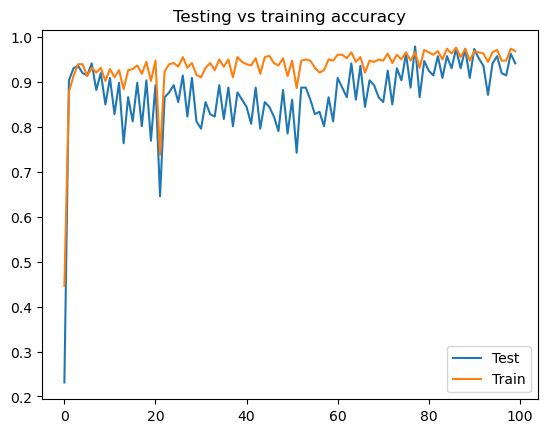

In [19]:
pm3.plot_accuracy()

In [20]:
pm3.show_confusion_matrix()

(0.8763440860215054, 1.0, 0.9125475285171103, 0.8391608391608392)

# PM4

In [21]:
dataset = pd.read_csv('../dataset.csv')
# Shuffling the dataset column wise
dataset_column_shuffled = dataset.sample(frac=1, axis=1)
dataset_column_shuffled.head()
# Convert cancer type into a new column
dataset_column_shuffled["cancer_type"] = pd.factorize(dataset_column_shuffled["diagnosis"])[0]
dataset_column_shuffled["cancer_type"] = dataset_column_shuffled["cancer_type"].replace(0, -1)
# Remove ID and diagnosis from the dataset
dataset_column_shuffled.drop(['id', 'diagnosis'], axis=1, inplace=True)
dataset_column_shuffled.head()

,radius_se,symmetry_worst,concavity_worst,fractal_dimension_se,perimeter_se,concavity_mean,fractal_dimension_worst,smoothness_worst,compactness_worst,fractal_dimension_mean,...,symmetry_se,compactness_se,texture_mean,symmetry_mean,perimeter_mean,concavity_se,smoothness_mean,area_mean,smoothness_se,cancer_type
0,1.0950,0.4601,0.7119,0.006193,8.589,0.3001,0.11890,0.1622,0.6656,0.07871,...,0.03003,0.04904,10.38,0.2419,122.80,0.05373,0.11840,1001.0,0.006399,-1
1,0.5435,0.2750,0.2416,0.003532,3.398,0.0869,0.08902,0.1238,0.1866,0.05667,...,0.01389,0.01308,17.77,0.1812,132.90,0.01860,0.08474,1326.0,0.005225,-1
2,0.7456,0.3613,0.4504,0.004571,4.585,0.1974,0.08758,0.1444,0.4245,0.05999,...,0.02250,0.04006,21.25,0.2069,130.00,0.03832,0.10960,1203.0,0.006150,-1
3,0.4956,0.6638,0.6869,0.009208,3.445,0.2414,0.17300,0.2098,0.8663,0.09744,...,0.05963,0.07458,20.38,0.2597,77.58,0.05661,0.14250,386.1,0.009110,-1
4,0.7572,0.2364,0.4000,0.005115,5.438,0.1980,0.07678,0.1374,0.2050,0.05883,...,0.01756,0.02461,14.34,0.1809,135.10,0.05688,0.10030,1297.0,0.011490,-1


In [22]:
# Make a pm1 model
pm4 = Perceptron(dataset=dataset_column_shuffled)

# Train using the epoch version of the code
w = pm4.epoch_train(epoch=20000, learning_rate=.3)

Vector w: [-2.4404340e+01 -1.4661840e+01 -2.4834150e+01 -4.9048350e-01
 -1.5888450e+02 -1.3362396e+01 -4.2987180e+00  1.5211200e+00
 -4.2754050e+01 -8.9278500e-01 -4.6761900e+02 -1.3742700e+03
 -3.8807880e+00 -2.7592830e+01 -5.3059200e-01 -1.8375510e+03
 -1.3248918e+01  8.5482900e+02  1.4882100e+02  2.3949900e+02
 -5.3013000e+00 -2.6052270e+00 -4.7641170e+00 -5.9011800e+02
  3.7950000e-01  1.1589480e+03 -3.3459750e+00  4.4438400e-01
  1.2593700e+03  1.4937960e-01  2.6400000e+01]
Number of Iterations: 1000


In [23]:
# Print testing and training accuracy for run2
print(pm4.check_training_accuracy())
print(pm4.check_test_accuracy())

0.48293963254593175
0.28191489361702127


In [24]:
# Print the max accuracy and the respective w for run2
pm4.max_accuracy

{'w': array([-2.4404340e+01, -1.4661840e+01, -2.4834150e+01, -4.9048350e-01,
        -1.5888450e+02, -1.3362396e+01, -4.2987180e+00,  1.5211200e+00,
        -4.2754050e+01, -8.9278500e-01, -4.6761900e+02, -1.3742700e+03,
        -3.8807880e+00, -2.7592830e+01, -5.3059200e-01, -1.8375510e+03,
        -1.3248918e+01,  8.5482900e+02,  1.4882100e+02,  2.3949900e+02,
        -5.3013000e+00, -2.6052270e+00, -4.7641170e+00, -5.9011800e+02,
         3.7950000e-01,  1.1589480e+03, -3.3459750e+00,  4.4438400e-01,
         1.2593700e+03,  1.4937960e-01,  2.6400000e+01]),
 'training_accuracy': 0.9133858267716536,
 'testing_accuracy': 0.8829787234042553,
 'confusion_matrix': (0.8829787234042553,
  0.9361702127659575,
  0.9230769230769231,
  0.9103448275862069)}

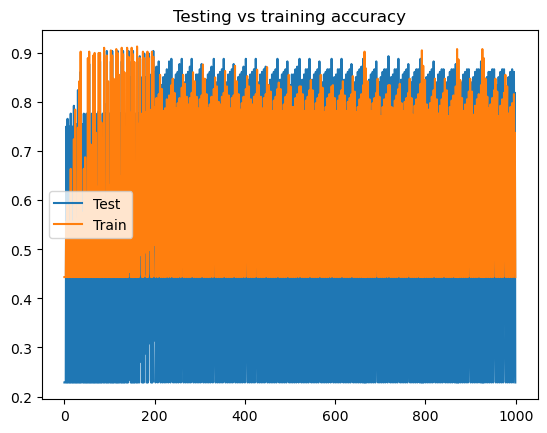

In [25]:
pm4.plot_accuracy()

In [26]:
pm4.show_confusion_matrix()

(0.28191489361702127, 1.0, 0.12903225806451613, 0.06896551724137931)

# 10 iterations for pm1, pm2, pm3, pm4 each

In [6]:
%%capture
EPOCHS = 1000
LEARNING_RATE = 0.3
pm1_details = {
    "training_accuracy": 0,
    "testing_accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}
pm2_details = {
    "training_accuracy": 0,
    "testing_accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}
pm3_details = {
    "training_accuracy": 0,
    "testing_accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}
pm4_details = {
    "training_accuracy": 0,
    "testing_accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}

for _ in range(10):
    # Read the csv file
    dataset = pd.read_csv('../dataset.csv')
    
    # Convert cancer type into a new column
    dataset["cancer_type"] = pd.factorize(dataset["diagnosis"])[0]
    dataset["cancer_type"] = dataset["cancer_type"].replace(0, -1)
    dataset.head()

    # Remove ID and diagnosis from the dataset
    dataset.drop(['id', 'diagnosis'], axis=1, inplace=True)

    # Drop NA rows because in first one we shouldn't use NA
    dropped_dataset = dataset.dropna()

    # Get pm2 ready
    shuffled_dataset2 = dropped_dataset.sample(frac=1, random_state=2)
    shuffled_dataset2.head()

    # Get pm4 ready
    dataset = pd.read_csv('../dataset.csv')
    # Shuffling the dataset column wise
    dataset_column_shuffled = dataset.sample(frac=1, axis=1)
    dataset_column_shuffled.head()
    # Convert cancer type into a new column
    dataset_column_shuffled["cancer_type"] = pd.factorize(dataset_column_shuffled["diagnosis"])[0]
    dataset_column_shuffled["cancer_type"] = dataset_column_shuffled["cancer_type"].replace(0, -1)
    # Remove ID and diagnosis from the dataset
    dataset_column_shuffled.drop(['id', 'diagnosis'], axis=1, inplace=True)
    dataset_column_shuffled.head()

    pm_1 = Perceptron(dataset=dropped_dataset)
    print("Executing model : pm_1")
    w = pm_1.epoch_train(epoch=EPOCHS, learning_rate=LEARNING_RATE)
    pm1_details["testing_accuracy_avg"] += pm_1.max_accuracy["confusion_matrix"][0] / 10
    pm1_details["precision_avg"] += pm_1.max_accuracy["confusion_matrix"][1] / 10
    pm1_details["f1_avg"] += pm_1.max_accuracy["confusion_matrix"][2] / 10
    pm1_details["recall_avg"] += pm_1.max_accuracy["confusion_matrix"][3] / 10

    pm_2 = Perceptron(dataset=shuffled_dataset2, is_normalized=False)
    print("Executing model : pm_2")
    w = pm_2.epoch_train(epoch=EPOCHS, learning_rate=LEARNING_RATE)
    pm2_details["testing_accuracy_avg"] += pm_2.max_accuracy["confusion_matrix"][0] / 10
    pm2_details["precision_avg"] += pm_2.max_accuracy["confusion_matrix"][1] / 10
    pm2_details["f1_avg"] += pm_2.max_accuracy["confusion_matrix"][2] / 10
    pm2_details["recall_avg"] += pm_2.max_accuracy["confusion_matrix"][3] / 10

    pm_3 = Perceptron(dataset=dropped_dataset, is_normalized=True)
    print("Executing model : pm_3")
    w = pm_3.epoch_train(epoch=EPOCHS, learning_rate=LEARNING_RATE)
    pm3_details["testing_accuracy_avg"] += pm_3.max_accuracy["confusion_matrix"][0] / 10
    pm3_details["precision_avg"] += pm_3.max_accuracy["confusion_matrix"][1] / 10
    pm3_details["f1_avg"] += pm_3.max_accuracy["confusion_matrix"][2] / 10
    pm3_details["recall_avg"] += pm_3.max_accuracy["confusion_matrix"][3] / 10

    pm_4 = Perceptron(dataset=dataset_column_shuffled, is_normalized=False)
    print("Executing model : pm_4")
    w = pm_4.epoch_train(epoch=EPOCHS, learning_rate=LEARNING_RATE)
    pm4_details["testing_accuracy_avg"] += pm_4.max_accuracy["confusion_matrix"][0] / 10
    pm4_details["precision_avg"] += pm_4.max_accuracy["confusion_matrix"][1] / 10
    pm4_details["f1_avg"] += pm_4.max_accuracy["confusion_matrix"][2] / 10
    pm4_details["recall_avg"] += pm_4.max_accuracy["confusion_matrix"][3] / 10


In [7]:
print(pm1_details)
print(pm2_details)
print(pm3_details)
print(pm4_details)

{'training_accuracy': 0, 'testing_accuracy_avg': 0.9032258064516129, 'precision_avg': 0.9310344827586204, 'f1_avg': 0.9375, 'recall_avg': 0.9440559440559438}
{'training_accuracy': 0, 'testing_accuracy_avg': 0.8870967741935486, 'precision_avg': 0.9090909090909093, 'f1_avg': 0.9128630705394191, 'recall_avg': 0.9166666666666666}
{'training_accuracy': 0, 'testing_accuracy_avg': 0.9731182795698924, 'precision_avg': 0.9999999999999999, 'f1_avg': 0.9822064056939503, 'recall_avg': 0.9650349650349652}
{'training_accuracy': 0, 'testing_accuracy_avg': 0.8829787234042553, 'precision_avg': 0.9361702127659576, 'f1_avg': 0.9230769230769231, 'recall_avg': 0.9103448275862069}
